Loading and processing data...


C:\Users\ARYAN PRAKASH\AppData\Local\Temp\ipykernel_12684\2090608038.py:47: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.read_csv(
C:\Users\ARYAN PRAKASH\AppData\Local\Temp\ipykernel_12684\2090608038.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_features = daily_groups.apply(self._time_features)


Starting training...
Epoch 1/100 | Loss: 0.0644
Epoch 11/100 | Loss: 0.0305
Epoch 21/100 | Loss: 0.0162
Epoch 31/100 | Loss: 0.0116
Epoch 41/100 | Loss: 0.0097
Epoch 51/100 | Loss: 0.0086
Epoch 61/100 | Loss: 0.0079
Epoch 71/100 | Loss: 0.0073
Epoch 81/100 | Loss: 0.0069
Epoch 91/100 | Loss: 0.0066

Detected 62 anomalies
Threshold: 0.0272
Top 5 Anomalies:
Index 300 - Score: 0.0608
Index 305 - Score: 0.0675
Index 307 - Score: 0.0778
Index 308 - Score: 0.0896
Index 306 - Score: 0.1000


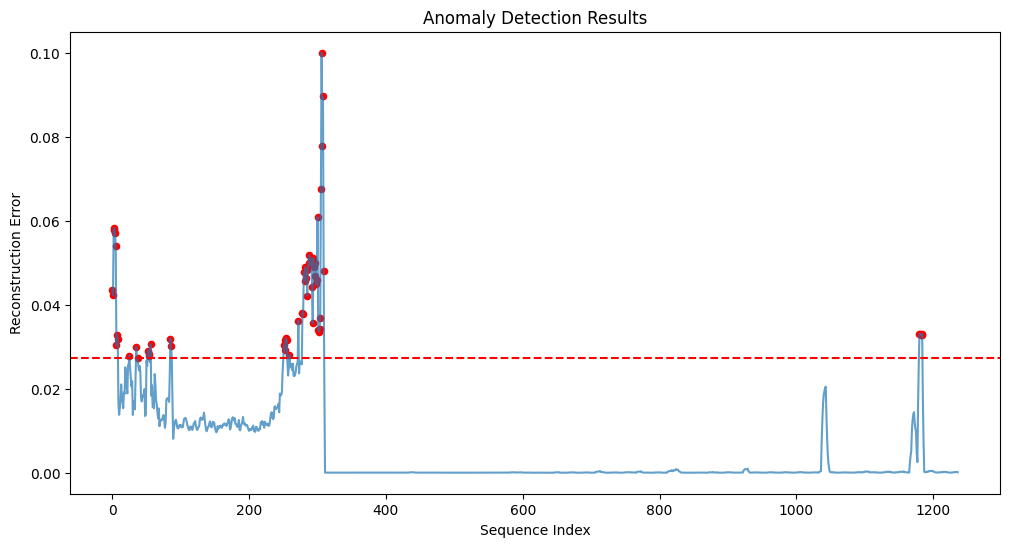

In [42]:
"""
Deep Learning for Web Server Log Anomaly Detection
LSTM Autoencoder Implementation for 10 Lakh+ Records
"""

# Import required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re
import string
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams  # Import ngrams

nltk.download("punkt", quiet=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Configuration
SEQUENCE_LENGTH = 7  # Days window for temporal analysis
BATCH_SIZE = 256  # Optimized for large datasets
EPOCHS = 100  # Training iterations
HIDDEN_SIZE = 64  # LSTM hidden units


class LogAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.scaler = MinMaxScaler()
        self.model = None
        self.sequences = None

    def _load_data(self):
        """Optimized data loading with memory management"""
        dtype_spec = {
            "IP Address": "category",
            "Timestamp": "string",
            "Request": "string",
            "Status": "int16",
        }
        return pd.read_csv(
            self.file_path,
            usecols=["IP Address", "Timestamp", "Request", "Status"],
            parse_dates=["Timestamp"],
            dtype=dtype_spec,
        )

    def _extract_features(self, df):
        """Vectorized feature extraction pipeline"""
        # Temporal features
        df["day"] = df.Timestamp.dt.date
        daily_groups = df.groupby("day")

        # Time difference statistics
        time_features = daily_groups.apply(self._time_features)

        # URL text analysis
        url_features = daily_groups.Request.apply(self._url_analysis)

        # IP/Status features
        ip_status = daily_groups.agg(
            {
                "IP Address": lambda x: x.mode()[0],
                "Status": lambda x: x.mode()[0],
                "Request": "count",
            }
        ).rename(columns={"Request": "request_count"})

        # Feature engineering
        ip_status["ip_numeric"] = ip_status["IP Address"].cat.codes
        features = pd.concat([time_features, url_features, ip_status], axis=1)

        # Handle categorical columns separately
        for col in features.select_dtypes(include=["category"]).columns:
            features[col] = features[col].cat.codes

        return features.fillna(0)

    def _time_features(self, group):
        """Vectorized time difference calculations"""
        times = group.Timestamp.sort_values()
        diffs = times.diff().dt.total_seconds().dropna()
        return pd.Series(
            {
                "time_max": diffs.max() if not diffs.empty else 0,
                "time_mean": diffs.mean() if not diffs.empty else 0,
                "time_sum": diffs.sum() if not diffs.empty else 0,
                "time_var": diffs.var() if not diffs.empty else 0,
            }
        )

    def _url_analysis(self, urls):
        """Optimized text processing pipeline"""
        text = " ".join(urls).lower()
        text = re.sub(r"\d+|[%s]" % re.escape(string.punctuation), "", text)
        tokens = [
            t for t in word_tokenize(text) if t not in {"get", "post", "http", "https"}
        ]

        counts = Counter(tokens)
        bigrams = Counter(ngrams(tokens, 2))
        trigrams = Counter(ngrams(tokens, 3))

        return pd.Series(
            {
                "top_page": counts.most_common(1)[0][1] if tokens else 0,
                "top_bigram": bigrams.most_common(1)[0][1] if bigrams else 0,
                "top_trigram": trigrams.most_common(1)[0][1] if trigrams else 0,
            }
        )

    def _create_sequences(self, data):
        """Create time-series sequences for LSTM"""
        scaled = self.scaler.fit_transform(data)
        sequences = []
        for i in range(len(scaled) - SEQUENCE_LENGTH):
            sequences.append(scaled[i : i + SEQUENCE_LENGTH])
        return torch.tensor(sequences, dtype=torch.float32)

    def build_model(self, input_size):
        """LSTM Autoencoder architecture"""

        class Autoencoder(nn.Module):
            def __init__(self):
                super().__init__()
                self.encoder = nn.LSTM(
                    input_size, HIDDEN_SIZE, batch_first=True, num_layers=2
                )
                self.decoder = nn.LSTM(
                    HIDDEN_SIZE, input_size, batch_first=True, num_layers=2
                )

            def forward(self, x):
                _, (hidden, _) = self.encoder(x)
                hidden = hidden[-1].unsqueeze(1).repeat(1, x.size(1), 1)
                decoded, _ = self.decoder(hidden)
                return decoded

        return Autoencoder()

    def train(self):
        """End-to-end training pipeline"""
        # Data processing
        print("Loading and processing data...")
        raw_data = self._load_data()
        features = self._extract_features(raw_data)
        self.sequences = self._create_sequences(features)

        # Train/test split
        train_data, test_data = train_test_split(
            self.sequences, test_size=0.2, shuffle=False
        )
        train_loader = DataLoader(
            TensorDataset(train_data, train_data), batch_size=BATCH_SIZE, shuffle=True
        )

        # Model setup
        self.model = self.build_model(features.shape[1])
        self.model = self.model.to(device)  # Move model to device
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        # Training loop
        print("Starting training...")
        losses = []
        for epoch in range(EPOCHS):
            self.model.train()
            epoch_loss = 0
            for batch in train_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(
                    device
                )  # Move data to device
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            losses.append(avg_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

        # Save training plot
        plt.plot(losses)
        plt.title("Training Loss Progress")
        plt.xlabel("Epochs")
        plt.ylabel("Reconstruction Error")
        plt.savefig("training_loss.png")
        plt.close()

        return losses

    def detect_anomalies(self, threshold=0.95):
        """Anomaly detection pipeline"""
        with torch.no_grad():
            self.model.eval()
            errors = []
            for i in range(0, len(self.sequences), BATCH_SIZE):
                batch = self.sequences[i : i + BATCH_SIZE].to(
                    device
                )  # Move data to device
                reconstructions = self.model(batch)
                batch_errors = torch.mean((batch - reconstructions) ** 2, dim=(1, 2))
                errors.extend(batch_errors.cpu().numpy())  # Move data to CPU

        errors = np.array(errors)
        threshold = np.quantile(errors, threshold)
        anomalies = errors > threshold

        # Visualization
        plt.figure(figsize=(12, 6))
        plt.plot(errors, alpha=0.7)
        plt.axhline(threshold, c="r", linestyle="--")
        plt.scatter(np.where(anomalies)[0], errors[anomalies], c="r", s=20)
        plt.title("Anomaly Detection Results")
        plt.xlabel("Sequence Index")
        plt.ylabel("Reconstruction Error")
        plt.savefig("anomalies.png")

        return anomalies, errors, threshold


# Sample Test Dataset Generation
def generate_test_data(days=180, anomalies=10):
    """Generate synthetic log data for testing"""
    base_features = {
        "time_max": np.random.normal(300, 50, days),
        "time_mean": np.random.normal(120, 20, days),
        "time_sum": np.random.normal(5000, 1000, days),
        "time_var": np.random.normal(2000, 500, days),
        "top_page": np.random.poisson(150, days),
        "top_bigram": np.random.poisson(75, days),
        "top_trigram": np.random.poisson(40, days),
        "request_count": np.random.normal(1000, 200, days),
        "ip_numeric": np.random.normal(1e10, 1e9, days),
    }

    # Inject anomalies
    for _ in range(anomalies):
        idx = np.random.randint(0, days)
        for feat in ["time_max", "time_sum", "request_count"]:
            base_features[feat][idx] *= 5

    return pd.DataFrame(base_features)


if __name__ == "__main__":
    # Example Usage
    test_data = generate_test_data()
    test_data.to_csv("../dataset/access_log.txt/test_data.csv", index=False)

    analyzer = LogAnalyzer("../dataset/access_log.txt/output.csv")
    analyzer.train()
    anomalies, scores, threshold = analyzer.detect_anomalies()

    print(f"\nDetected {sum(anomalies)} anomalies")
    print(f"Threshold: {threshold:.4f}")
    print("Top 5 Anomalies:")
    for idx in np.argsort(scores)[-5:]:
        print(f"Index {idx} - Score: {scores[idx]:.4f}")